# Neural Collapse and Data Distillatioin

This notebook implements a visualization page for the data distillation algorithm utilizing the neural collapse. 

The main papers considered here are 
 - data distillation:
     - https://github.com/SsnL/dataset-distillation 
     - https://github.com/google-research/google-research/tree/master/kip
 - Neural Collapse:
     - https://github.com/tding1/Neural-Collapse. 

The neural network has fixed the last layer weight matrix to be a simplex ETF. The ETF is a benign optimization landscape empeirically observed in practice as long as the network enters its terminal phase.

Below we configure our path to the dataset distillation packages from https://github.com/SsnL/dataset-distillation.

# Import

In [1]:
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torch.nn.functional as F

import numpy as np
import pickle
import scipy.linalg as scilin

import matplotlib.pyplot as plt
import time


import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torchsummary import summary

Let's import the file from the https://github.com/tding1/Neural-Collapse.

In [4]:
import models
from models import resnet_decode
from models.res_adapt import ResNet18_adapt
from utils import *

from train_encoder import train
from validate_NC import *

from validate_NC import compute_Wh_b_relation, compute_W_H_relation, compute_ETF, compute_Sigma_B, compute_Sigma_W,compute_info,FCFeatures
from data.datasets import make_dataset
from data.data_loading import get_cifar10_data_loaders
from arg_loader import *

# Load Parameters

In [5]:
# architecture params
encoder='resnet18'
bias=True
ETF_fc=True
fixdim=10
SOTA=True

# MLP settings (only when using mlp and res_adapt(in which case only width has effect))
width=1024
depth=6

# hardware settings
gpu_id=1
seed=6
use_cudnn=True

# dataset
dataset='cifar10'
data_dir='~/data'
uid="Resnet18-design-Adam-SOTA"
force=True

# learning options
epochs = 200
batch_size = 64
loss = 'CrossEntropy'
sample_size = None

# optimization
lr=0.001
history_size=10
optimizer = "Adam"
patience = 40

## Check the best device on machine
check = False

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(gpu_id))
    device_name = torch.cuda.get_device_name(0)
    # 
    torch.cuda.empty_cache()
    if check:
        torch.cuda.memory_allocated()
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"Using device: {device}, {device_name}")

Using device: cuda:1, NVIDIA TITAN V


In [7]:
args = train_args(model=encoder,bias=bias,ETF_fc=ETF_fc,fixdim=fixdim,SOTA=SOTA,
                  width=width,depth=depth,
                  gpu_id=gpu_id,seed=seed,use_cudnn=use_cudnn,
                  dataset=dataset,data_dir=data_dir,uid=uid,force=force,
                  epochs=epochs,batch_size = batch_size,loss = loss,sample_size=sample_size,
                  lr = lr,optimizer=optimizer, patience = patience,
                  device = device)

override this uidResnet18-design-Adam-SOTA
cudnn is used


# Load Dataset

In [36]:
trainloader, testloader, num_classes = make_dataset(dataset, 
                                           data_dir, 
                                           batch_size, 
                                           SOTA=SOTA)
images, labels = next(iter(trainloader))
size_train, channels, height, width = images.shape
input_size = height, width, channels
print("The number of class in our training set is ", num_classes)
print("Batch size: %d | Input size: %s" % (size_train,input_size))

Dataset: CIFAR10.
Files already downloaded and verified
Files already downloaded and verified
The number of class in our training set is  10
Batch size: 64 | Input size: (32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


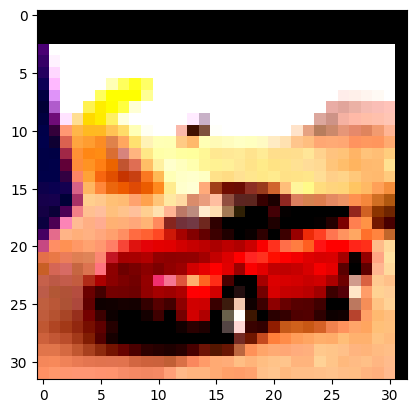

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


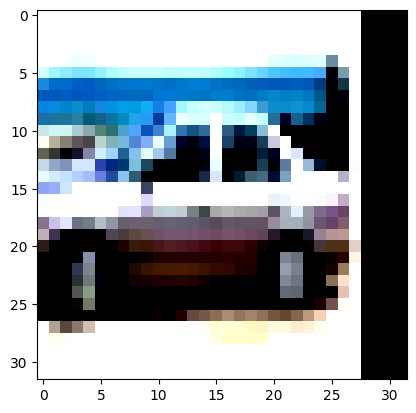

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


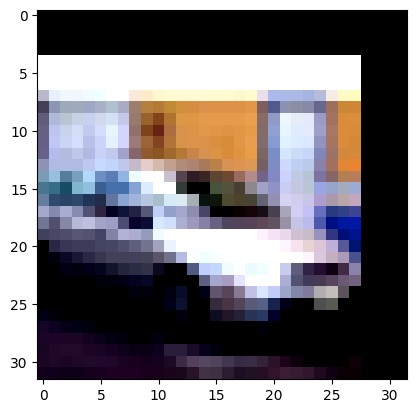

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


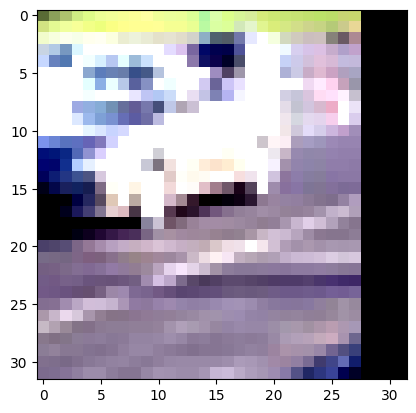

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


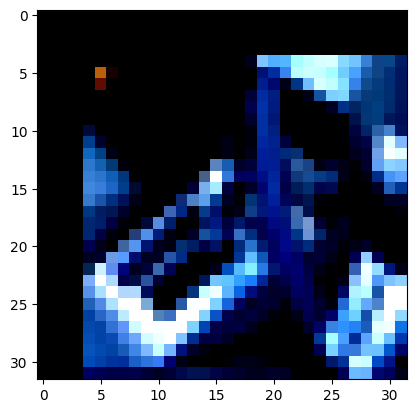

IndexError: index 64 is out of bounds for dimension 0 with size 64

In [37]:
from Visualization import imshow
from Visualization import visualize_one_image_per_class
# Check if trainloader is loaded
if trainloader is None:
    raise ValueError("Trainloader is not loaded. Please load it before running this script.")

imgs, lbls = next(iter(trainloader))
for i in range(100):  # show just the frogs
    if lbls[i] == 1:  # 6 = frog
        imshow(tv.utils.make_grid(imgs[i]))


Traceback (most recent call last):
  File "/home/songze/miniconda3/envs/mlenv/lib/python3.11/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/songze/miniconda3/envs/mlenv/lib/python3.11/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/songze/miniconda3/envs/mlenv/lib/python3.11/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/songze/miniconda3/envs/mlenv/lib/python3.11/shutil.py", line 738, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/songze/miniconda3/envs/mlenv/lib/python3.11/shutil.py", line 736, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-_40_yefb'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

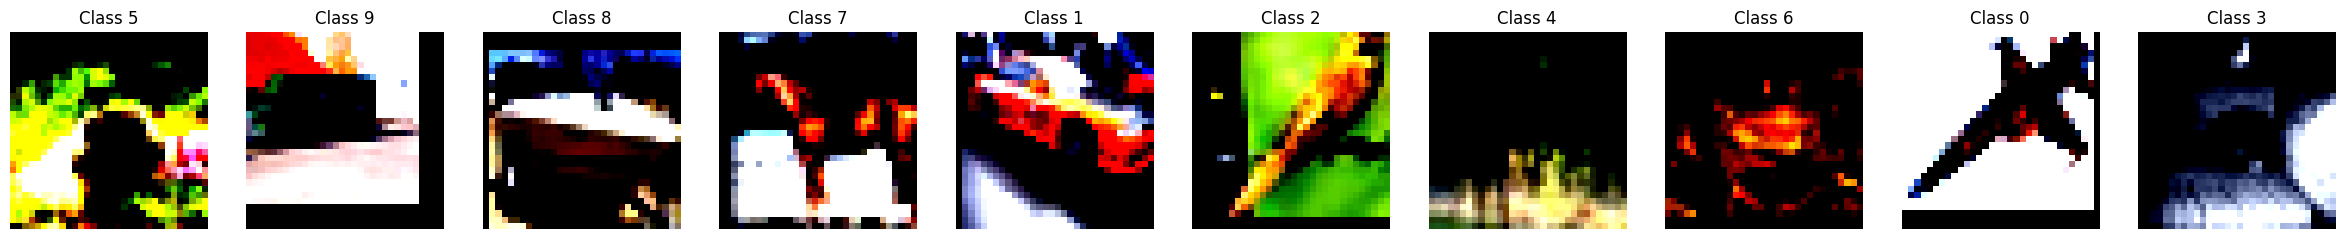

In [38]:
visualize_one_image_per_class(trainloader)

In [39]:
print(len(images))
print(len(labels))

64
64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


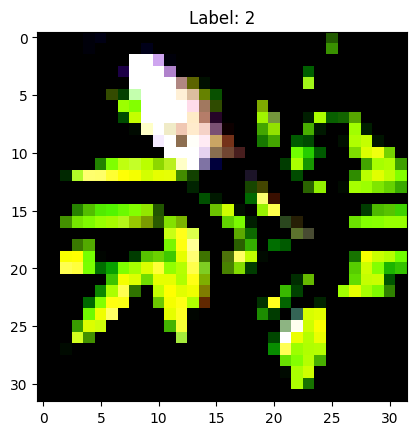

In [40]:

image_to_plot = images[6].numpy().transpose(1, 2, 0)

# If the data was normalized, you may need to denormalize it
# image_to_plot = image_to_plot * std + mean  # Uncomment if needed

plt.imshow(image_to_plot)
plt.title(f'Label: {labels[6]}')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


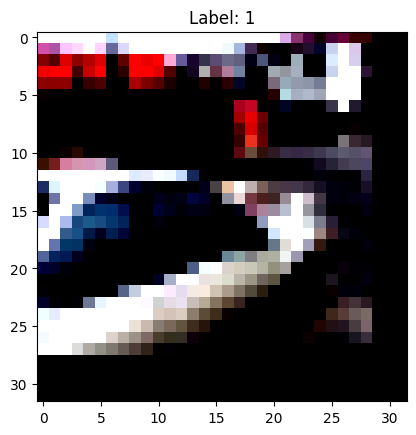

In [44]:
trainset = trainloader.dataset

dataponit = trainset[49999]  # This returns a tuple (image, label)
image, label = dataponit

image_to_plot = image.numpy().transpose(1, 2, 0)

# If the data was normalized, you may need to denormalize it
# image_to_plot = image_to_plot * std + mean  # Uncomment if needed

plt.imshow(image_to_plot)
plt.title(f'Label: {label}')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

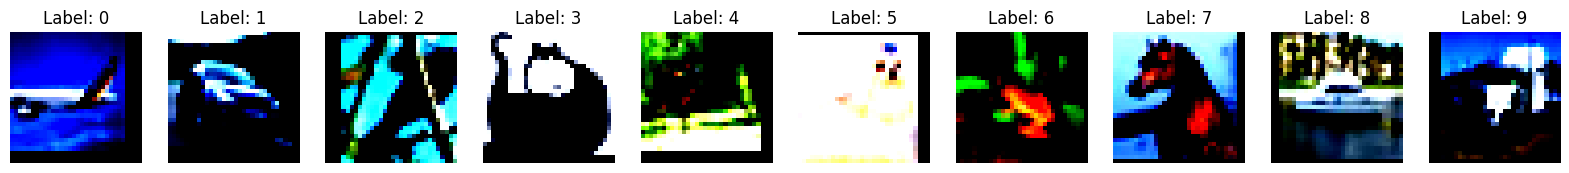

In [51]:
# Create a dictionary to store indices for each class
class_indices = {i: [] for i in range(10)}  # MNIST has 10 classes, labeled 0-9

# Populate the dictionary with indices for each class
for idx, (_, label) in enumerate(trainset):
    class_indices[label].append(idx)

# Select one random index from each class
selected_indices = [random.choice(class_indices[i]) for i in range(10)]

# Extract images from these indices
selected_images = [trainset[i][0].numpy().transpose(1, 2, 0) for i in selected_indices]
selected_labels = [trainset[i][1] for i in selected_indices]

# Plotting
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  # Adjust size as needed
for ax, img, label in zip(axes, selected_images, selected_labels):
    ax.imshow(img.squeeze())  # img.squeeze() to remove channel dim if it's 1
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()
